In [1]:
import numpy as np
import pandas as pd
import vectorbtpro as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='both',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.fetch('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2021-12-05 00:00:00+00:00    49368.847656
2021-12-06 00:00:00+00:00    50582.625000
2021-12-07 00:00:00+00:00    50700.085938
2021-12-08 00:00:00+00:00    50504.796875
2021-12-09 00:00:00+00:00    48258.980469
Name: Close, Length: 2637, dtype: float64


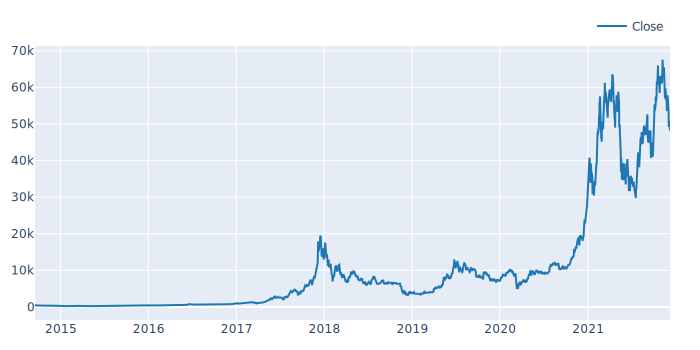

In [5]:
price.vbt.plot().show_svg()

In [6]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

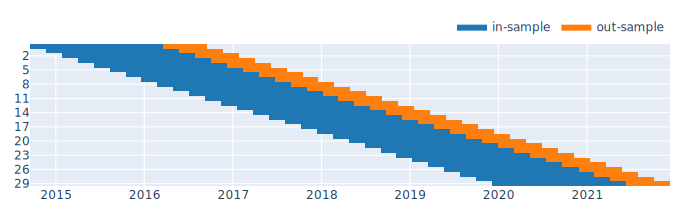

In [7]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [8]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [11]:
def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.sharpe_ratio

In [12]:
in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.567356
2     1.343788
3     1.362551
4     1.812064
5     1.835919
6     2.002450
7     2.368802
8     2.746147
9     2.868753
10    3.062637
11    2.425139
12    2.190841
13    1.963913
14    1.825288
15    0.897729
16    0.575476
17    0.466068
18   -0.119204
19    0.328454
20    0.231318
21    0.490719
22    0.553348
23    0.656786
24    1.211913
25    1.279815
26    1.079108
27    1.538247
28    2.098022
29    1.721961
Name: sharpe_ratio, dtype: float64


In [14]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio

In [15]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **pf_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.229036
                          1            0.321070
                          2            0.207363
                          3            0.243022
                          4            0.409689
                                         ...   
48           49           25          -1.167717
                          26          -1.159245
                          27          -0.774842
                          28          -0.528603
                          29          -0.471015
Name: sharpe_ratio, Length: 23400, dtype: float64


In [16]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [17]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(26, 29,  0),
            (27, 28,  1),
            (21, 26,  2),
            (23, 28,  3),
            (20, 41,  4),
            (36, 47,  5),
            (32, 47,  6),
            (37, 43,  7),
            (16, 19,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 22, 13),
            (10, 22, 14),
            (10, 23, 15),
            (17, 23, 16),
            (18, 20, 17),
            (18, 19, 18),
            (18, 19, 19),
            (45, 49, 20),
            (45, 49, 21),
            (19, 20, 22),
            (14, 16, 23),
            (14, 16, 24),
            (28, 29, 25),
            (13, 20, 26),
            (13, 20, 27),
            (25, 26, 28),
            (24, 41, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [18]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [19]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[26 29]
 [27 28]
 [21 26]
 [23 28]
 [20 41]
 [36 47]
 [32 47]
 [37 43]
 [16 19]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 23]
 [17 23]
 [18 20]
 [18 19]
 [18 19]
 [45 49]
 [45 49]
 [19 20]
 [14 16]
 [14 16]
 [28 29]
 [13 20]
 [13 20]
 [25 26]
 [24 41]]


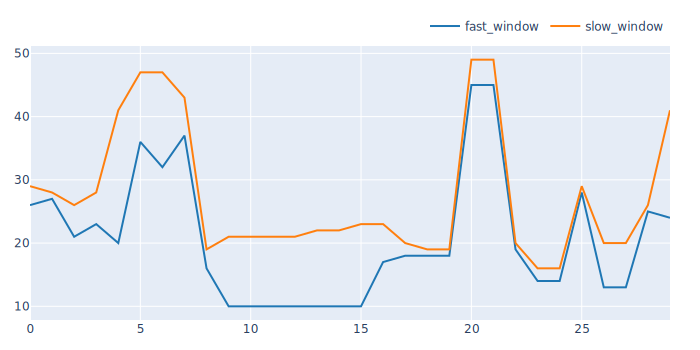

In [20]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [21]:
out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     2.125840
2     1.538578
3     2.143661
4     3.957013
5     3.388590
6     3.830162
7     4.098132
8     2.033762
9     1.039014
10   -1.527349
11   -0.831844
12   -0.789766
13   -2.005863
14   -1.428894
15    2.544333
16    3.351680
17    1.631937
18   -0.308144
19    0.188362
20   -0.058919
21    1.040498
22    1.006142
23    2.636862
24    5.121603
25    4.791306
26    2.257844
27    0.968324
28   -0.008371
29    0.967944
Name: sharpe_ratio, dtype: float64


In [22]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0            1.059386
                          1           -1.351689
                          2           -1.022855
                          3            1.557374
                          4            3.642302
                                         ...   
48           49           25           1.960700
                          26          -0.280536
                          27          -1.305335
                          28           0.752045
                          29          -0.279848
Name: sharpe_ratio, Length: 23400, dtype: float64


In [25]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio

In [26]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **pf_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
26         29         0            1.415715
27         28         1           -0.946774
21         26         2            1.313549
23         28         3           -1.717435
20         41         4            1.475485
36         47         5           -0.757412
32         47         6           -1.510779
37         43         7            3.793117
16         19         8            2.132601
10         21         9            0.971131
                      10           1.130267
                      11           1.044461
                      12          -0.207691
           22         13          -1.688021
                      14          -1.281970
           23         15           3.632791
17         23         16           2.075987
18         20         17          -0.551991
           19         18           0.787292
                      19          -0.141643
45         49         20          -2.035214
                      21          -0.703503


In [27]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

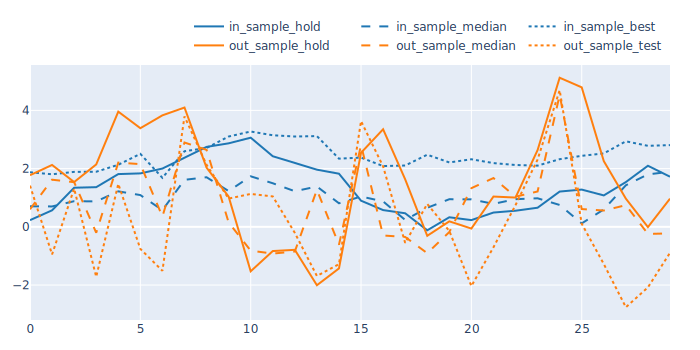

In [28]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()